# Credit score classification project

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn.model_selection import train_test_split
import seaborn as sns

# Train test split
First of all we need to split our data into train, validation and test sets.

Even though there is a test set given in the competition files, we don't have any access to the target variables, so we decided to use train.csv file only

In [2]:
data = pd.read_csv('train.csv') # dataframe contains everything, not only train
# test = pd.read_csv('test.csv') this one doesn't works - missing target value

test_size = 0.2
X = data.drop(columns=["Credit_Score"]).copy()
y = data["Credit_Score"] # the target 


X_rem, X_test, y_rem, y_test = train_test_split(X,y, test_size=test_size, shuffle=False) 
X_train, X_val, y_train, y_val = train_test_split(X_rem, y_rem, test_size=test_size, shuffle=False)

C:\Users\tymot\AppData\Local\Temp\ipykernel_21756\3620597250.py:1: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('train.csv') # dataframe contains everything, not only train


In [3]:
# merged in order to perfrom preprocessing efficiently
train = X_train.join(y_train)
val = X_val.join(y_val)
test = X_test.join(y_test)

In [4]:
train.to_csv("data/train.csv")
val.to_csv("data/val.csv")
test.to_csv("data/test.csv")

(array([11469.,     0.,     0.,     0.,     0., 33817.,     0.,     0.,
            0., 18714.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

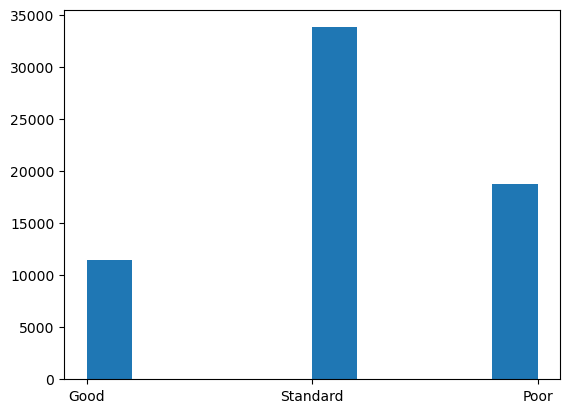

In [5]:
plt.hist(train["Credit_Score"])


<Axes: >

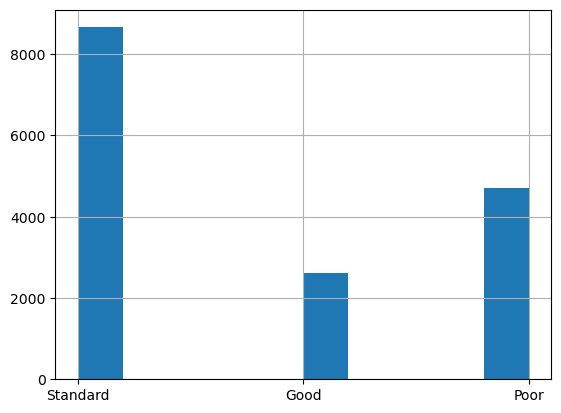

In [6]:
val["Credit_Score"].hist()

the variables are distributed similary

# Data Examination

is placed in a different file in order to improve this file readability 

# Data Preprocessing

First of all we git rid of columns that carry the same information

In [7]:
def id_columns(df):
    df = df.drop(["Name", "SSN", "ID"], axis="columns") # no added value, all the information in Customer_ID
    df["Customer_ID"] = df["Customer_ID"].apply(lambda x: int(x[4:], 16)) # convert to int
    
    print("Columns containing id-like information preprocessed")
    return df

Here we literally 'clean' the data, removing unnecessary signs that appear randomly

In [8]:
def clear_numeric_data(col):
    # some of the rows contain "_" sign
    col.astype(str).replace("_", "")
    return pd.to_numeric(col, errors="coerce") # errors='coerce', then invalid parsing will be set as NaN

In [9]:
# function for cleaning numeric data where necessary
def altering(df):
    
    columns_to_alter = ['Age', 'Annual_Income', 'Num_of_Loan','Num_of_Delayed_Payment',
                        'Changed_Credit_Limit', 'Outstanding_Debt',
                        'Amount_invested_monthly', 'Monthly_Balance']

    df[columns_to_alter] = df[columns_to_alter].apply(clear_numeric_data, axis=1)

    print("Numeric data preprocessed. Columns with numeric values contain numeric only variables. Changed columns types")
    return df

Function below helps with removal outlying values from a column.
If parameter (use_quantiles) is False, removes outliers outside given set range (a, b).
Otherwise removes top 2 quantiles

In [10]:
def delete_outliers(column, a=0, b=0.98, use_quantiles=True):
    # function helps removing quantiles from a column, 
    # if parameter (use_quantiles) is False, removes outliers outside given range (a, b)
    # otherwise removes top quantiles
    
    col = np.where(a < column, column, float('nan'))
    if use_quantiles:
        return np.where(col <= column.quantile(b), column, float('nan'))
    return np.where(col <= b, column, float('nan'))


def handle_outliers(df):
    df["Age"] = np.where((0 > df["Age"]), -df["Age"], df["Age"]) # deleting weird outliers
    df['Age'] = delete_outliers(df["Age"], 0, 100, use_quantiles=False)
    
    df["Annual_Income"] = delete_outliers(df["Annual_Income"], 0, 0.99)
    df["Num_Bank_Accounts"] = delete_outliers(df["Num_Bank_Accounts"])
    df["Num_of_Loan"] = delete_outliers(df["Num_of_Loan"])
    df["Interest_Rate"] = delete_outliers(df["Interest_Rate"])
    df["Num_Credit_Card"] = delete_outliers(df["Num_Credit_Card"], 0, 0.97)
    df["Num_of_Delayed_Payment"] = delete_outliers(df["Num_of_Delayed_Payment"])
    df["Num_Credit_Inquiries"] = delete_outliers(df["Num_Credit_Inquiries"])
    df["Total_EMI_per_month"] = delete_outliers(df["Total_EMI_per_month"], 0, 0.95)


    print("Deleted outliers")   
    
    return df

## Encoding categorical data
some variables contain categorical data - we want to save the unique values from them in order to apply one-hot encoding

In [11]:
train["Occupation"] = np.where(train["Occupation"] == "_______", "Unknown", train["Occupation"])
occupations_list = train["Occupation"].unique()
occupations_list

array(['Scientist', 'Unknown', 'Teacher', 'Engineer', 'Entrepreneur',
       'Developer', 'Lawyer', 'Media_Manager', 'Doctor', 'Journalist',
       'Manager', 'Accountant', 'Musician', 'Mechanic', 'Writer',
       'Architect'], dtype=object)

Sometimes when data is missing, it's possible to avail rows that pertain to the same customer and contain missing information.

In [12]:
# first we fill the information for customers that have other rows with full information available
train['Type_of_Loan'].fillna(train.groupby('Customer_ID')['Type_of_Loan'].first(), inplace=True)
# later we fill with ''
train['Type_of_Loan'].fillna('', inplace=True)
    
loan_types_list =  train['Type_of_Loan'].value_counts().head(9).index[1:] 

In [13]:
def encode_categorical(df):
    # encode columns where necessary (Credit_Mix, Payment_of_Min_Amount, Credit_Score)
    # mapping
    credit_mix_dict = {'Bad':0, 'Standard':1, 'Good':2, '_':float('nan')}
    poma_dict = {'No':0, 'Yes':1, 'NM':float('nan')}
    credit_score_dict = {'Poor':0, 'Standard':1, 'Good':2}
    month_dict = {"January": 1, "February": 2, "March": 3, "April": 4, "May": 5,
                "June": 6, "July": 7, "August": 8}
    
    df['Payment_of_Min_Amount'] = df['Payment_of_Min_Amount'].map(poma_dict)
    df['Credit_Mix'] = df['Credit_Mix'].map(credit_mix_dict)
    df['Credit_Score'] = df['Credit_Score'].map(credit_score_dict) # this might be incorrect (?)
    df["Month"] = df["Month"].map(month_dict)
    
    # Payment_Behaviour column brings two informations, one about spending, other about value payments
    df["Payment_Behaviour"] = df["Payment_Behaviour"].replace('!@9#%8', 'Unknown_spent_Unknown_value_payments')
    split_payment = lambda x:  ([x.split("_")[0], x.split("_")[2]] if (x is not None) else ["Unknown", "Unknown"])
    df["Payment_Behaviour"] = df["Payment_Behaviour"].apply(split_payment)
    df[["Spending_Behaviour", "Value_Payments"]] = pd.DataFrame(df["Payment_Behaviour"].tolist(), index=df.index)
    
    spending_dict = {'Low':0, 'High':1, 'Unknown':float('nan')}
    value_dict = {'Small':0, 'Medium':1, 'Large':2,  'Unknown':float('nan')}
    df['Spending_Behaviour'] = df['Spending_Behaviour'].map(spending_dict)
    df['Value_Payments'] = df['Value_Payments'].map(value_dict)
    
    del df["Payment_Behaviour"]
    
    
    for loan_type in loan_types_list: # the single types of loans
        df[loan_type] = df['Type_of_Loan'].str.contains(loan_type).astype("bool")
    del df["Type_of_Loan"]
    
    
    # credit history age    
    df['Credit_History_Age'] = df['Credit_History_Age'].apply(history_age)
    
    # Occupation - ____ for uneployed
    df["Occupation"] = np.where(df["Occupation"] == "_______", "Unknown", df["Occupation"])
    df["Occupation"] = np.where(df["Occupation"].isin(occupations_list), df["Occupation"], "Unknown") # to handle different occupations in test data
    df = df.join(pd.get_dummies(df['Occupation']))
    del df["Occupation"]

    print("Categorical columns with string values encoded. Added new columns where necessary (one-hot encoding)")
    
    return df

## handling NaNs

We will impute missing data. In case of some values we look up to rows containing
data about the same customer, using mode/median of values pertaining to him. If for customer
there are no other rows, we impute using globally most common values.

In [14]:
def impute_values(df):
    
    continuous_values = ['Monthly_Inhand_Salary', 'Amount_invested_monthly',
                         'Monthly_Balance', 'Credit_History_Age', "Outstanding_Debt",
                         "Changed_Credit_Limit", "Annual_Income"]
    
    for column in continuous_values:
        df[column] = df[column].fillna(df.groupby('Customer_ID')[column].transform("mean"))
    # using mean is not causing any trouble here, we're practically taking the value that appears
    # in the rows with the same id
        
    
    discrete_columns = ["Age", "Num_Credit_Inquiries", "Num_of_Loan", "Credit_Mix",
                        "Num_of_Delayed_Payment", "Num_Credit_Inquiries", 
                        "Spending_Behaviour", "Payment_of_Min_Amount", "Value_Payments"]
    # for discrete values we'll impute nans with mode
    for column in discrete_columns:
        #train[column].fillna(train.groupby('Customer_ID')[column].agg(lambda x: pd.Series.mode(x)[0]), inplace=True) 
        df[column].fillna(df.groupby('Customer_ID')[column].transform('median'), inplace=True) 
        pass
    
    df = df.fillna(df.median()) # in case a customer doesn't have any entries


    print("NA values imputed within numeric columns")

    return df


In [15]:
# processing Credit_History_Age so that's continuous
import re
def history_age(age):
    try : 
        years = int(re.findall('[0-9]+', age)[0])
        month = int(re.findall('[0-9]+', age)[1])
        return years*12 + month
    except :
        return np.nan
    
import re

In [16]:
def impute_discrete_string(df):

    discrete_string_columns = ["Occupation", "Type_of_Loan", "Payment_Behaviour"]
    # fill missing data in columns that are strings

    for column in discrete_string_columns:
        most_common_globally = df[column].agg(lambda x: pd.Series.mode(x)[0])
        df[column].fillna(df.groupby('Customer_ID')[column].agg(
            lambda x: (most_common_globally if len(pd.Series.mode(x)) == 0 else pd.Series.mode(x)[0])
            ), inplace=True) 
        

    print("NA values imputed within text columns")
        
    return df

## Pipeline

to faciliate the data preprocessing process we used pipeline

In [17]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline

drop_transformer = FunctionTransformer(id_columns)
altering_transformer = FunctionTransformer(altering)
outlier_transformer = FunctionTransformer(handle_outliers)
categorical_transformer = FunctionTransformer(encode_categorical)
imputer_transformer = FunctionTransformer(impute_values)
discrete_imputer_transformer = FunctionTransformer(impute_discrete_string)

# all the afore declared processings applied
prepipe = Pipeline([
    ("drop", drop_transformer),
    ("altering", altering_transformer),
    ("outliers", outlier_transformer),
    ("impute_discrete_string", discrete_imputer_transformer),
    ("categorical", categorical_transformer),
    ("impute", imputer_transformer)
])


In [18]:
train = prepipe.fit_transform(train)

Columns containing id-like information preprocessed
Numeric data preprocessed. Columns with numeric values contain numeric only variables. Changed columns types
Deleted outliers
NA values imputed within text columns
Categorical columns with string values encoded. Added new columns where necessary (one-hot encoding)
NA values imputed within numeric columns


In [19]:
# verify the pipe transformation
described = train.describe()
described

,Customer_ID,Month,Age,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,...,Journalist,Lawyer,Manager,Mechanic,Media_Manager,Musician,Scientist,Teacher,Unknown,Writer
count,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,...,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000
mean,25971.554125,4.500000,33.286594,50691.516723,4202.890997,5.632812,5.519922,14.499156,3.999875,21.120750,...,0.062578,0.066016,0.059734,0.062312,0.061500,0.057000,0.064531,0.063156,0.069906,0.060406
std,14318.333131,2.291306,10.736895,39084.296653,3194.906200,2.301489,2.035677,8.693652,2.088167,14.823882,...,0.242205,0.248311,0.236996,0.241724,0.240247,0.231844,0.245699,0.243246,0.254991,0.238240
min,1006.000000,1.000000,14.000000,7005.930000,319.556250,1.000000,1.000000,1.000000,1.000000,-5.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,13920.750000,2.750000,25.000000,19300.340000,1628.847500,4.000000,4.000000,8.000000,2.000000,10.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,25699.500000,4.500000,33.000000,36963.890000,3084.000000,6.000000,5.000000,13.000000,4.000000,18.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38352.250000,6.250000,42.000000,71738.280000,5961.745000,7.000000,7.000000,20.000000,5.000000,28.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,50999.000000,8.000000,100.000000,781808.000000,15204.633333,10.000000,10.000000,60.000000,9.000000,67.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


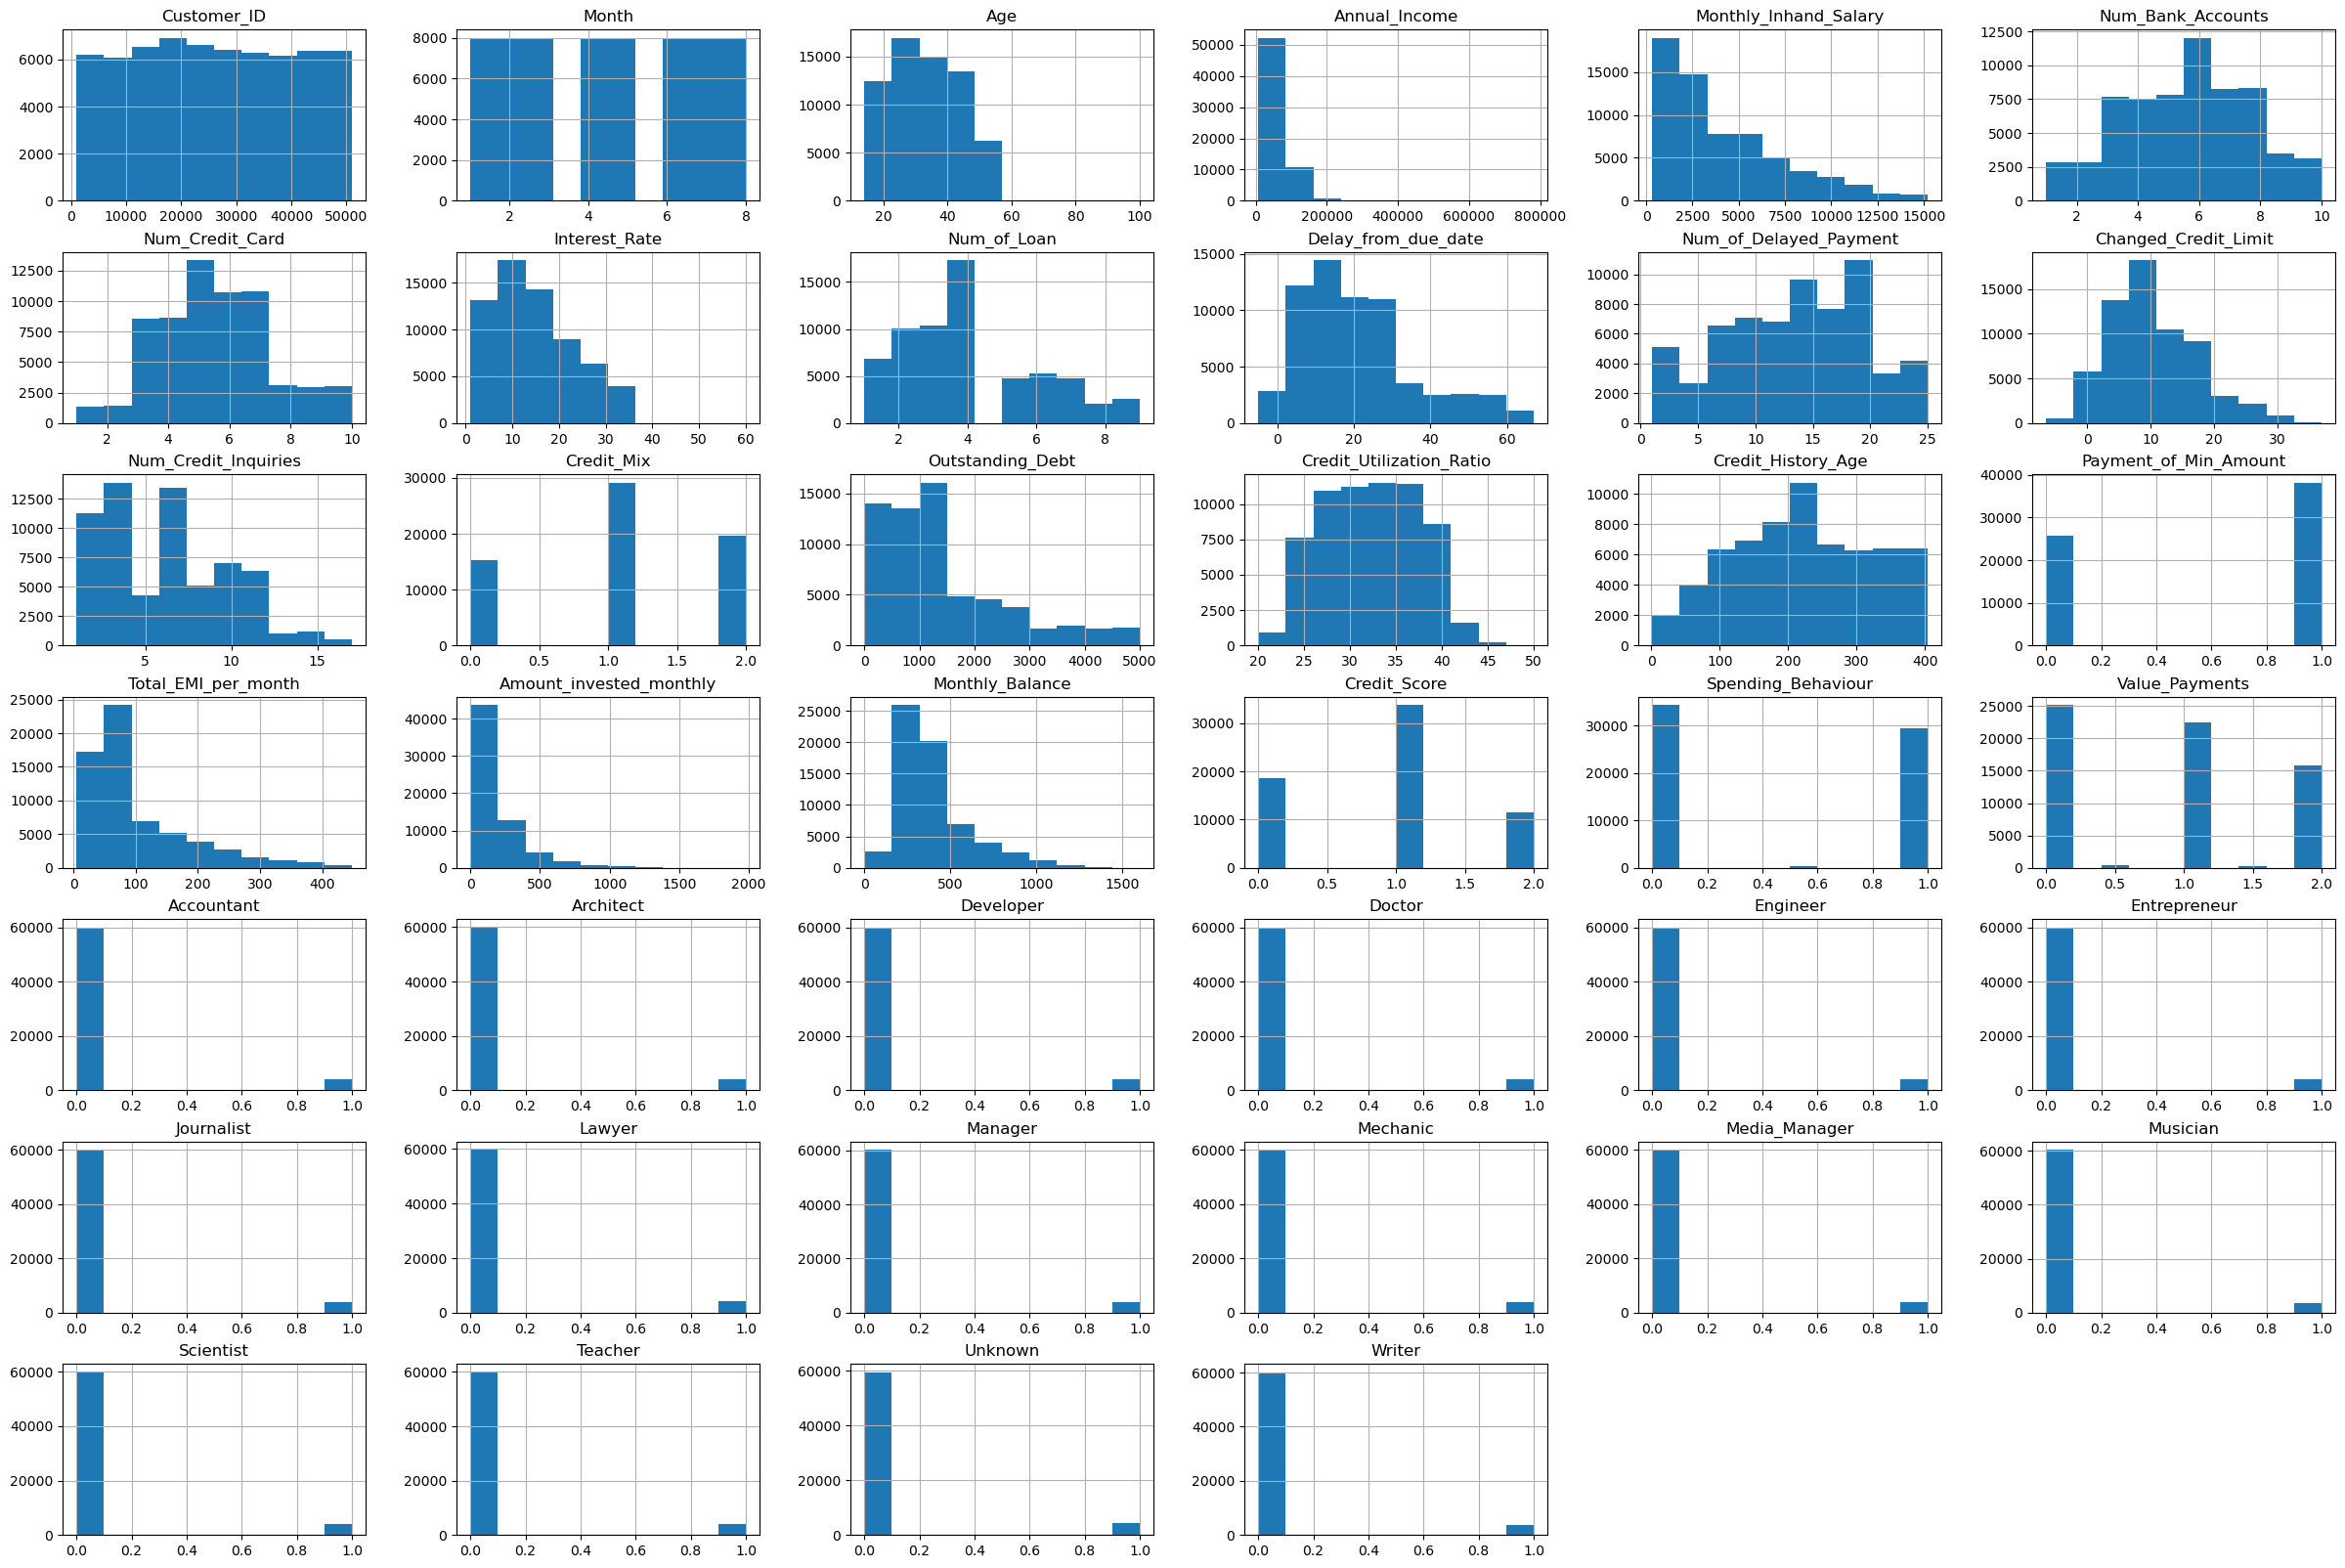

In [20]:
hist_plot = train.hist(figsize=(30, 20))
plt.show()

<Axes: >

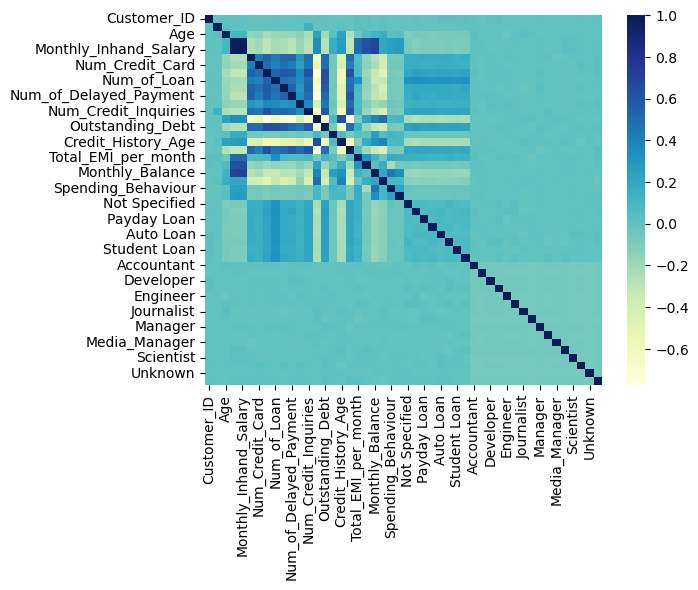

In [21]:
sns.heatmap(train.corr(), cmap="YlGnBu") # correlation map

# Model

We will initially create the models, to check which features have the highest importance.
Our intention is to drop the irrelevant later after the 1st model fitting.

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

In [23]:
# training dataset
y = train['Credit_Score']
del train['Credit_Score']
y_train = y
X_train = train

In [24]:
# validation dataset
val = prepipe.transform(val)
X_val = val
y_val = val["Credit_Score"]
del X_val["Credit_Score"]

Columns containing id-like information preprocessed
Numeric data preprocessed. Columns with numeric values contain numeric only variables. Changed columns types
Deleted outliers
NA values imputed within text columns
Categorical columns with string values encoded. Added new columns where necessary (one-hot encoding)
NA values imputed within numeric columns


# Random Forest

1st fitting

In [25]:
from sklearn.ensemble import RandomForestClassifier

In [26]:
rf_model = RandomForestClassifier(n_estimators=120)
rf_model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=120)

In [33]:
y_pred = rf_model.predict(X_val)

In [34]:
print(classification_report(y_pred, y_val))

              precision    recall  f1-score   support

           0       0.66      0.71      0.69      4380
           1       0.73      0.75      0.74      8397
           2       0.65      0.53      0.58      3223

    accuracy                           0.69     16000
   macro avg       0.68      0.66      0.67     16000
weighted avg       0.69      0.69      0.69     16000



# Verify feature importance in random forest model

Our goal is to select the most predictive variables, as the credit score prediction has to be explainable.

In [94]:
feature_importances = pd.DataFrame(rf_model.feature_importances_,
                                   X_val.columns,
                                   columns=['Importance'])

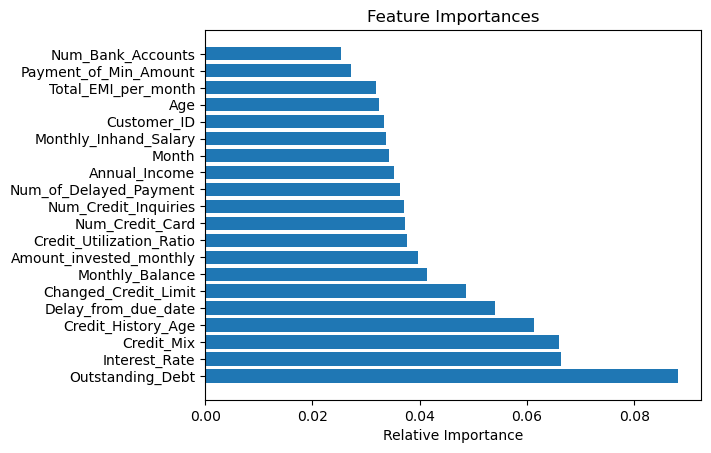

In [95]:
feature_importance_sorted = feature_importances.sort_values(by='Importance', ascending=False).head(20)

plt.title('Feature Importances')

plt.barh(feature_importance_sorted.index, feature_importance_sorted["Importance"])
plt.xlabel('Relative Importance')
plt.show()

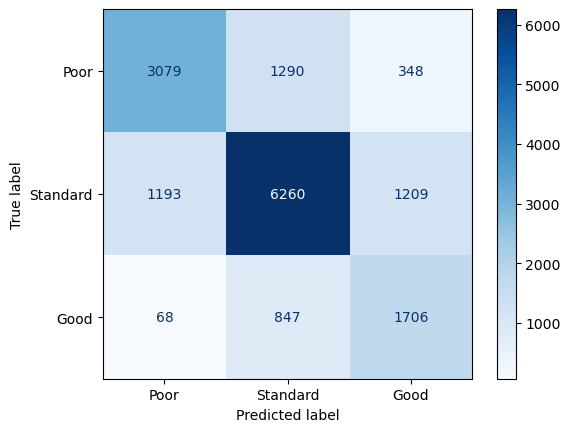

In [106]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


class_names = ['Poor', 'Standard', 'Good']
cm = confusion_matrix(y_val, y_pred, labels=class_names)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)

# shapley examination

A handy library `shap` comes to rescue - it provides some robust tools that helps explaining the model's behaviour.

In [125]:
import shap
shap.initjs() # this code should execute within 5 min

In [182]:
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_train)

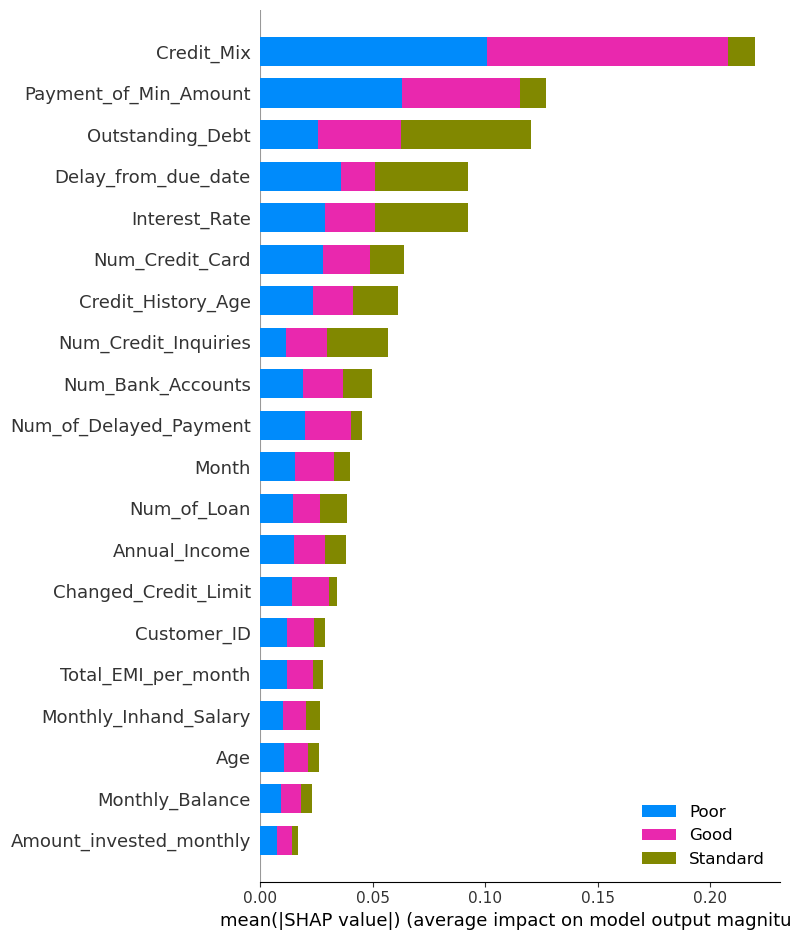

In [110]:
shap.summary_plot(shap_values, X_train.loc[1:100, :].values, plot_type="bar", class_names= class_names, feature_names = X_train.loc[1:100, :].columns)

in the example above we can see for instance that model doesn't use much information from feature 'Credit_Mix' when it comes to predicting label 'Standard'

below we can see plot showing the importance of features while predicting label 'Poor' - value 0

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


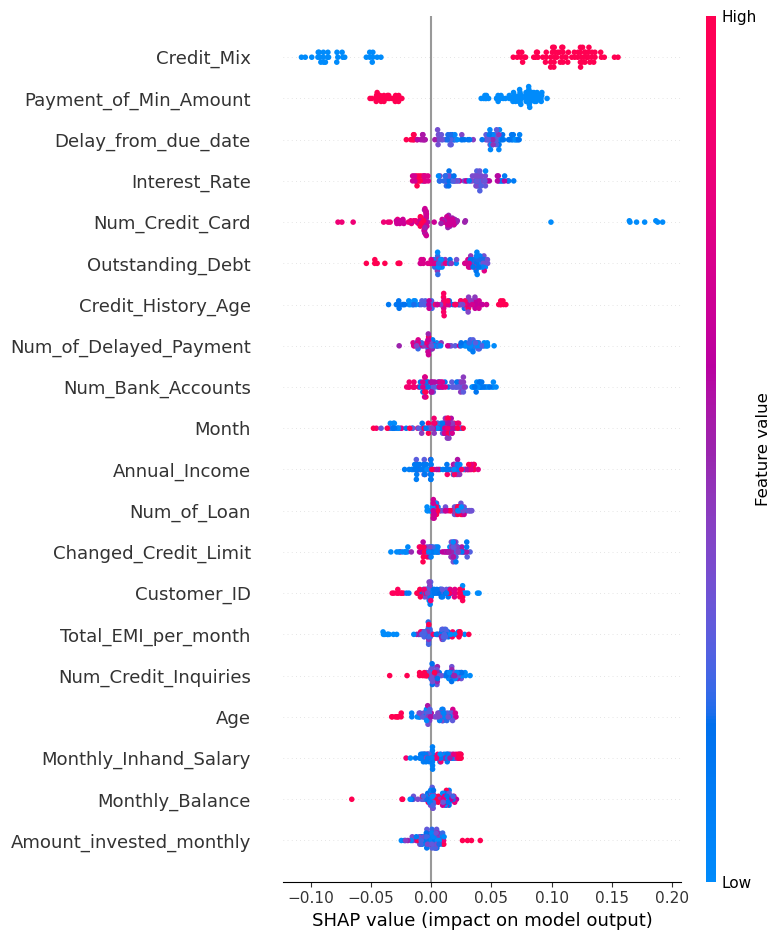

In [150]:
shap.summary_plot(shap_values[0], X_train.loc[1:100, :].values, feature_names = X_train.columns)

As it turns out the most important variable is `Credit Mix`, which refers to the types of different credit accounts you have – mortgages, loans, credit cards, etc. It is a kind of assessment of the current credit that the bank sets before signing the contract for new services.

Credit Mix can be easily improved by paying installments on time, setting up a credit card for a small amount and maintaining it regularly, etc.

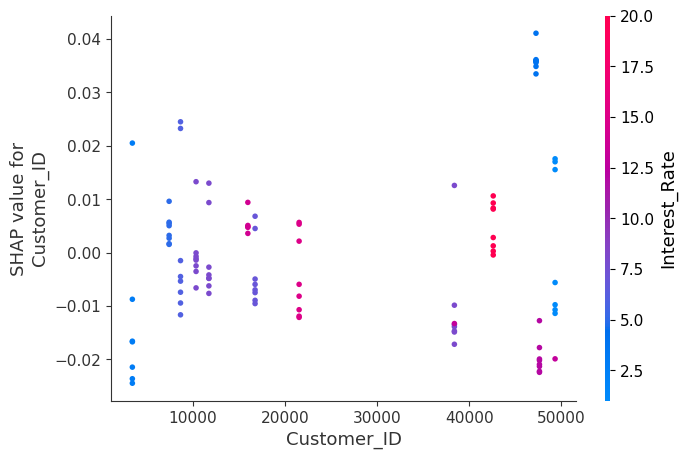

In [151]:
shap.dependence_plot(0, shap_values[2], X_train.loc[1:100, :].values, feature_names=X_train.columns)

In [152]:
# single observation

row=70
shap.force_plot(explainer.expected_value[0], shap_values[0][row], X_train.loc[1:100, :].values[row], feature_names = X_train.columns)

In [153]:
y_train[row]

'Good'

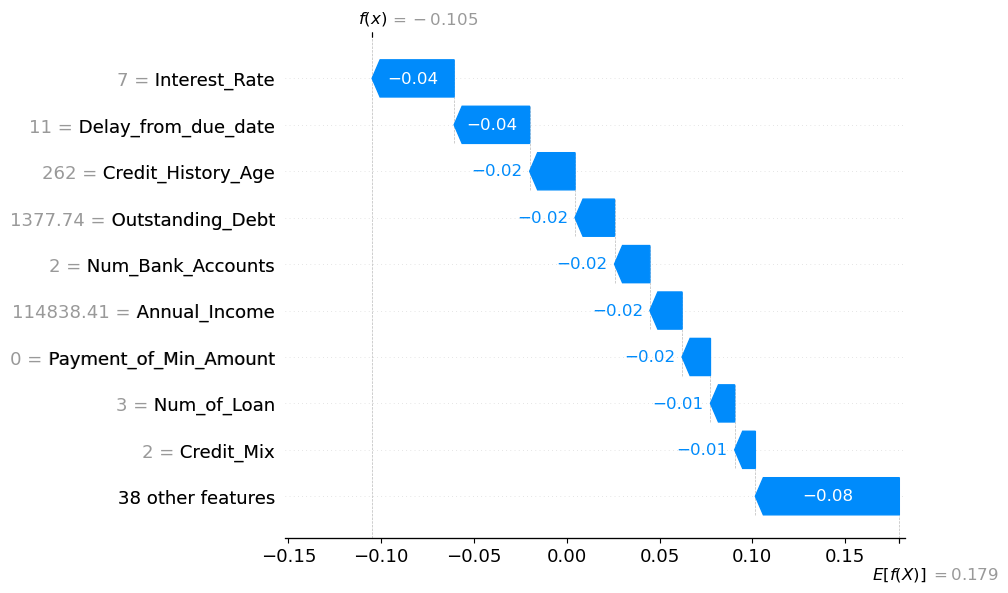

In [159]:

shap.waterfall_plot(shap.Explanation(values=shap_values[1][row], 
                                              base_values=explainer.expected_value[0], data=X_train.iloc[row],  
                                         feature_names=X_train.columns.tolist()))

it looks like if the credit mix is higher, there is greater chance that model will clasify the observation with better category 

In [180]:
df = X_train[["Credit_Mix"]].join(y_train).groupby(["Credit_Mix", "Credit_Score"]).agg(count=('Credit_Score', 'count')).reset_index()
df = df.pivot(index="Credit_Mix", columns="Credit_Score", values="count")  

Credit_Score,Good,Poor,Standard
Credit_Mix,,,
0.0,237,9157,5870
1.0,1692,6250,21218
2.0,9540,3307,6729


# Dropping highly correlated columns

In [217]:
columns_to_delete = []
for i in range(len(X_train.columns)):
    for j in range(i+1, len(X_train.columns)):
        # we iterate over every pair of columns
        # if the correlation between them is over 0.5 we eliminate the less predictive (for our particular model) column
        if (abs(X_train[X_train.columns[i]].corr(X_train[X_train.columns[j]])) > 0.7):
            if feature_importances.loc[X_train.columns[i]][0] < feature_importances.loc[X_train.columns[j]][0]:
                columns_to_delete.append(feature_importances.loc[X_train.columns[i]].name)
            else:
                columns_to_delete.append(feature_importances.loc[X_train.columns[j]].name)

In [218]:
columns_to_delete.append('Customer_ID')
columns_to_delete = list(set(columns_to_delete)) # get unique values
columns_to_delete

['Payment_of_Min_Amount',
 'Monthly_Inhand_Salary',
 'Interest_Rate',
 'Num_of_Delayed_Payment',
 'Customer_ID',
 'Annual_Income']

In [219]:
X_train_2 = X_train.drop(columns_to_delete, axis=1)
X_val_2 = X_val.drop(columns_to_delete, axis=1) 

In [220]:
feature_importances_2 = feature_importances.loc[feature_importances.index.isin(X_train_2)].sort_values(by='Importance', ascending=False)
feature_importances_2

,Importance
Outstanding_Debt,0.094029
Credit_Mix,0.068787
Credit_History_Age,0.059387
Delay_from_due_date,0.054500
Changed_Credit_Limit,0.049073
Num_Credit_Card,0.040585
Monthly_Balance,0.040552
Amount_invested_monthly,0.039465
Credit_Utilization_Ratio,0.037793
Num_Credit_Inquiries,0.036266


# New model, trained without highly correlated columns

In [221]:
rf_model_2 = RandomForestClassifier(n_estimators=100)
rf_model_2.fit(X_train_2, y_train)

RandomForestClassifier()

In [222]:
y_pred_2 = rf_model_2.predict(X_val_2)

In [223]:
print(classification_report(y_pred_2, y_val))

              precision    recall  f1-score   support

           0       0.65      0.70      0.68      4418
           1       0.73      0.74      0.73      8572
           2       0.60      0.52      0.56      3010

    accuracy                           0.69     16000
   macro avg       0.66      0.65      0.66     16000
weighted avg       0.68      0.69      0.68     16000



# XGBoost attempt

In [224]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import (
    BaggingClassifier,
    ExtraTreesClassifier,
    RandomForestClassifier,
    StackingClassifier,
    HistGradientBoostingClassifier
)
from xgboost import XGBClassifier

In [225]:
gbc_model= GradientBoostingClassifier()
gbc_model.fit(X_train, y_train)

GradientBoostingClassifier()

In [226]:
y_pred_xgboost = gbc_model.predict(X_val)

In [227]:
print(classification_report(y_pred_xgboost, y_val))

              precision    recall  f1-score   support

           0       0.66      0.71      0.68      4351
           1       0.73      0.75      0.74      8427
           2       0.66      0.54      0.59      3222

    accuracy                           0.70     16000
   macro avg       0.68      0.66      0.67     16000
weighted avg       0.69      0.70      0.69     16000



XGBoost Classifier hasn't turned out to be much better than the Random Forest Classifier.

# Stacked Classifier

In [228]:
bagging = BaggingClassifier(n_jobs=-1)
extraTrees = ExtraTreesClassifier(max_depth=10, n_jobs=-1)
randomForest = RandomForestClassifier(n_jobs=-1)
histGradientBoosting = HistGradientBoostingClassifier()
XGB = XGBClassifier(n_jobs=-1)

model = StackingClassifier([
    ('bagging', bagging),
    ('extraTress', extraTrees),
    ('randomforest', randomForest),
    ('histGradientBoosting', histGradientBoosting),
    ('XGB', XGB)
], n_jobs=-1)

In [229]:
model.fit(X_train, y_train)

StackingClassifier(estimators=[('bagging', BaggingClassifier(n_jobs=-1)),
                               ('extraTress',
                                ExtraTreesClassifier(max_depth=10, n_jobs=-1)),
                               ('randomforest',
                                RandomForestClassifier(n_jobs=-1)),
                               ('histGradientBoosting',
                                HistGradientBoostingClassifier()),
                               ('XGB',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None...
                                              gpu_id=None, grow_policy=None,
                                              importance_type=None,
                                              interaction_constraints=None,
                                              learning_rate=None, max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None,
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              n_estimators=100, n_jobs=-1,
                                              num_parallel_tree=None,
                                              predictor=None, random_state=None, ...))],
                   n_jobs=-1)

In [230]:
y_pred = model.predict(X_val)
print(classification_report(y_pred,y_val))

              precision    recall  f1-score   support

           0       0.65      0.72      0.68      4240
           1       0.75      0.73      0.74      8860
           2       0.61      0.55      0.58      2900

    accuracy                           0.70     16000
   macro avg       0.67      0.67      0.67     16000
weighted avg       0.70      0.70      0.70     16000



although we tried to choose the best model using many different types of models, each of them proved to be very similarly effective

# Attempt to drop irrelevant features with SelectKBest 

In [231]:
from sklearn.feature_selection import SelectKBest
#from sklearn.feature_selection import chi2

In [232]:
bestfeatures = SelectKBest(k=10)

In [233]:
fit = bestfeatures.fit(X_train,y_train)

In [234]:
fit.scores_

array([4.78381071e+00, 4.00107511e+01, 8.49721330e+02, 1.33840612e+03,
       1.49516193e+03, 5.00194713e+03, 5.98143338e+03, 9.25898486e+03,
       3.72131677e+03, 7.25459533e+03, 5.51425243e+03, 1.74620115e+03,
       7.06616872e+03, 1.14521115e+04, 5.61755859e+03, 6.60751011e+01,
       5.64908739e+03, 9.10897385e+03, 6.27194860e+01, 8.30285366e+02,
       1.39416227e+03, 2.87501667e+02, 2.86493339e+02, 5.91010078e+02,
       6.22699993e+02, 5.99176798e+02, 6.00616462e+02, 7.37530145e+02,
       6.18279951e+02, 6.14347072e+02, 5.37599583e+02, 3.67357075e+00,
       1.93172232e+00, 3.55413317e+00, 2.71446480e-01, 1.49388953e+01,
       4.30350174e-01, 7.72380350e+00, 2.77792301e+00, 4.36311000e-01,
       2.89439655e+00, 3.02378608e+00, 9.76627923e-02, 4.92649303e+00,
       2.00724211e+00, 3.41780464e-01, 2.91126886e+01])

In [235]:
featureScores = pd.DataFrame(fit.scores_, X_train.columns,  columns=['Importance_Score'])
featureScores = featureScores.sort_values(by='Importance_Score', ascending=False).head(20)

In [236]:
featureScores

,Importance_Score
Credit_Mix,11452.111478
Interest_Rate,9258.984865
Payment_of_Min_Amount,9108.973853
Delay_from_due_date,7254.595331
Num_Credit_Inquiries,7066.168720
Num_Credit_Card,5981.433376
Credit_History_Age,5649.087390
Outstanding_Debt,5617.558586
Num_of_Delayed_Payment,5514.252428
Num_Bank_Accounts,5001.947129


# New model without features with less importance

In [237]:
X_train_3 = X_train[featureScores.index]
X_val_3 = X_val[featureScores.index]

In [238]:
model.fit(X_train_3, y_train)

C:\Users\Aleks\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


StackingClassifier(estimators=[('bagging', BaggingClassifier(n_jobs=-1)),
                               ('extraTress',
                                ExtraTreesClassifier(max_depth=10, n_jobs=-1)),
                               ('randomforest',
                                RandomForestClassifier(n_jobs=-1)),
                               ('histGradientBoosting',
                                HistGradientBoostingClassifier()),
                               ('XGB',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None...
                                              gpu_id=None, grow_policy=None,
                                              importance_type=None,
                                              interaction_constraints=None,
                                              learning_rate=None, max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None,
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              n_estimators=100, n_jobs=-1,
                                              num_parallel_tree=None,
                                              predictor=None, random_state=None, ...))],
                   n_jobs=-1)

In [239]:
y_pred = model.predict(X_val_3)
print(classification_report(y_pred,y_val))

              precision    recall  f1-score   support

           0       0.64      0.72      0.68      4213
           1       0.73      0.74      0.74      8525
           2       0.66      0.53      0.59      3262

    accuracy                           0.69     16000
   macro avg       0.68      0.66      0.67     16000
weighted avg       0.69      0.69      0.69     16000



selecting columns in different ways did not bring the expected result - models trained on fewer columns did not perform better, although they can be better explained. 
We become convinced that the most predictive variables are `Credit_Mix`, `Interest_Rate`, `Payment_of_Min_Amount` and other columns describing the credit cards usage or variables describing whether payments were made on time. Features chosen by the model are explainable and its behaviour is explainable.

# lazy predict

In [41]:
from lazypredict.Supervised import LazyClassifier

clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(X_train, X_val, y_train, y_val)
models

100%|██████████| 29/29 [42:00<00:00, 86.91s/it]   


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
BernoulliNB,0.62,0.68,None,0.62,0.19
LGBMClassifier,0.70,0.68,None,0.70,2.46
GaussianNB,0.61,0.67,None,0.61,0.22
RandomForestClassifier,0.70,0.67,None,0.70,23.17
SVC,0.68,0.67,None,0.68,402.03
ExtraTreesClassifier,0.68,0.66,None,0.68,15.94
NearestCentroid,0.58,0.66,None,0.59,0.17
XGBClassifier,0.69,0.66,None,0.69,17.49
LinearDiscriminantAnalysis,0.65,0.64,None,0.65,0.91


# Hiperparameter tuning

In [37]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score

In [36]:
print('Parameters currently in use:\n')
print(rf_model.get_params())

Parameters currently in use:

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 120, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


In [38]:
k_values = [i for i in range (5,20,3)]
scores = []

for k in k_values:
    rf = RandomForestClassifier(max_depth=k)
    score = cross_val_score(rf, X_train, y, cv=5)
    scores.append(np.mean(score))
    print(f"{k} job done")

5 job done
8 job done
11 job done
14 job done
17 job done


Text(0, 0.5, 'Accuracy Score')

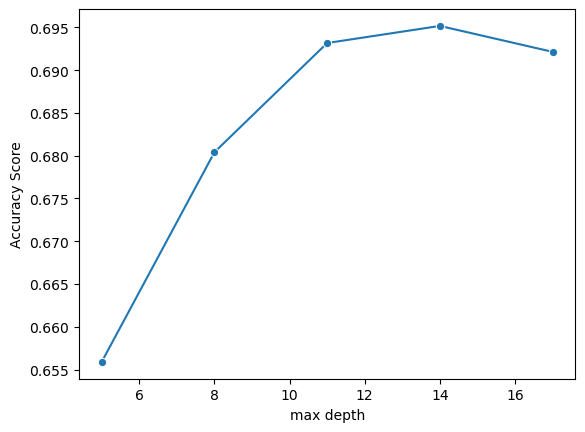

In [40]:
sns.lineplot(x = k_values, y = scores, marker = 'o')
plt.xlabel("max depth")
plt.ylabel("Accuracy Score")

it looks like the best accuracy results are for models with parameter `max_depth` around 13.

In [52]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [53]:
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores - it takes a lot of time btw
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


: 

In [58]:

# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [15, 30, 50, 100],
    'max_features': [3, 4],
    'min_samples_leaf': [2, 3, 4],
    'min_samples_split': [10, 12],
    'n_estimators': [500, 1000, 2000]
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 2, n_jobs = -1, verbose = 3)

In [59]:
grid_search.fit(X_train, y_train)
grid_search.best_score_

Fitting 2 folds for each of 144 candidates, totalling 288 fits


0.691015625

In [60]:
import pickle

filename = "saved_models/rf_grid_2.sav" # save the model for later - unfortunately the file is too big to send it over
pickle.dump(grid_search.best_estimator_, open(filename, 'wb'))
grid_search.best_params_ 

{'bootstrap': True,
 'max_depth': 30,
 'max_features': 4,
 'min_samples_leaf': 3,
 'min_samples_split': 10,
 'n_estimators': 1000}

In [61]:
rf_model = grid_search.best_estimator_

In [62]:
y_pred = rf_model.predict(X_val)
print(classification_report(y_pred,y_val))

              precision    recall  f1-score   support

           0       0.64      0.71      0.68      4267
           1       0.71      0.75      0.73      8200
           2       0.70      0.52      0.59      3533

    accuracy                           0.69     16000
   macro avg       0.68      0.66      0.67     16000
weighted avg       0.69      0.69      0.69     16000



# Summary

During the first project in the subject Introduction to Machine Learning, we created a classifying model predicting a **Credit Score** value for different clients, based on some data about them. 

After thorough data exploration we prepared a preprocessing pipeline that was handling the missing data, incorrect data formatting, outliers. Then, the cleaned data could be used to train different models and evaluate their performance with different grades. 

We also made a feature selection and investigated the model's choices, since its behaviour should be explainable by the problem it solves.

After testing different types and models and tuning their hyperparameters, we choose one model - **Random Forest Classifier** that has been saved to a file for later evalution.